In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import functions_ai

In [2]:
#print(os.getcwd())

## 1) Setup 

In [3]:
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')] #verschillende metrics vergelijken

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

## 2) Build initial model

In [4]:
custom_preprocessing = functions_ai.custom_preprocessing
batch_size = 128
img_height = img_width = 299

#set the paths/directories
path = pathlib.Path('covid xray')
train_dir = os.path.join(path, 'train') #just gives the path 
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#print(train_dir)

In [5]:
image_gen_train_aug = ImageDataGenerator(
                    rescale=1./255,
                    preprocessing_function=custom_preprocessing,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen_aug = image_gen_train_aug.flow_from_directory(batch_size=batch_size, 
                                               directory=train_dir, #implementation/loading of our data 
                                               shuffle=True,
                                               target_size=(img_height, img_width),  #pre-processing (together with scaler in ImageDataGenerator
                                                class_mode='binary')

image_gen_val = ImageDataGenerator(rescale = 1./255, preprocessing_function = custom_preprocessing)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, 
                                               directory=validation_dir, #implementation/loading of our data 
                                               shuffle=False,
                                               target_size=(img_height, img_width),  #pre-processing (together with scaler in ImageDataGenerator
                                                class_mode='binary')

image_gen_test = ImageDataGenerator(rescale = 1./255) #needed if load images using flow_from_directory()
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size, 
                                               directory=test_dir, #implementation/loading of our data 
                                               shuffle=False,
                                               target_size=(img_height, img_width),  #pre-processing (together with scaler in ImageDataGenerator
                                                class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    
    Conv2D(16, 3, padding='same', activation='relu'), #remark: still debate over ReLu -> BN (theoretical) / BN -> ReLu (in practice) [both used]
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.1), #dont 'kill' important features (in beginning most low levels features are learned)
    
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2), #somewhat more severe dropout
    
    Flatten(),
    Dense(512, activation='relu'), #in dense layers dropout of 0.5, in general more dropout at end bcs more prone to overfitting (more abstract features learned at end)
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 299, 299, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 149, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,859,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,884,449 (171.22 MB)

 Trainable params: 44,884,225 (171.22 MB)

 Non-trainable params: 224 (896.00 B)

## 3) Train your model

In [8]:
EPOCHS = 30

In [9]:
#choose loss function binary cross entropy
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics= metrics)

In [13]:
#Train your initial model on the COVID dataset for thirty epochs while HOLDING OUT the validation set to monitor its performance.

image_gen_train_aug2 = ImageDataGenerator(
                    rescale=1./255,
                    preprocessing_function=custom_preprocessing,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5, validation_split = 0.2 #validation split on training data 
                    )



# Define train and validation generators
train_data_gen_aug2 = image_gen_train_aug2.flow_from_directory(directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',  # ← this is important
    shuffle=True
)

val_data_gen2 = image_gen_train_aug2.flow_from_directory(directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # ← this gives you the hold-out validation set
    shuffle=False
)

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [14]:
history = model.fit(
    train_data_gen_aug2,
    steps_per_epoch=train_data_gen_aug2.samples // batch_size,
    validation_data=val_data_gen2,
    validation_steps=val_data_gen2.samples // batch_size,
    epochs=30,
    verbose=1
)

/opt/anaconda3/envs/AI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - accuracy: 0.5805 - auc: 0.6140 - loss: 14.1917 - precision: 0.5598 - recall: 0.5643 - val_accuracy: 0.6250 - val_auc: 0.5000 - val_loss: 6.9754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.6292 - auc: 0.6539 - loss: 5.2032 - precision: 0.6431 - recall: 0.6296 - val_accuracy: 0.6211 - val_auc: 0.4969 - val_loss: 6.3227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - accuracy: 0.6938 - auc: 0.7547 - loss: 1.4487 - precision: 0.6959 - recall: 0.6801 - val_accuracy: 0.6250 - val_auc: 0.4866 - val_loss: 5.0701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.6983 - auc: 0.7553 - loss: 1.0573 - precision: 0.6919 - recall: 0.6864 - val_accuracy: 0.6250 - val_auc: 0.5191 - val_loss: 4.9336 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5

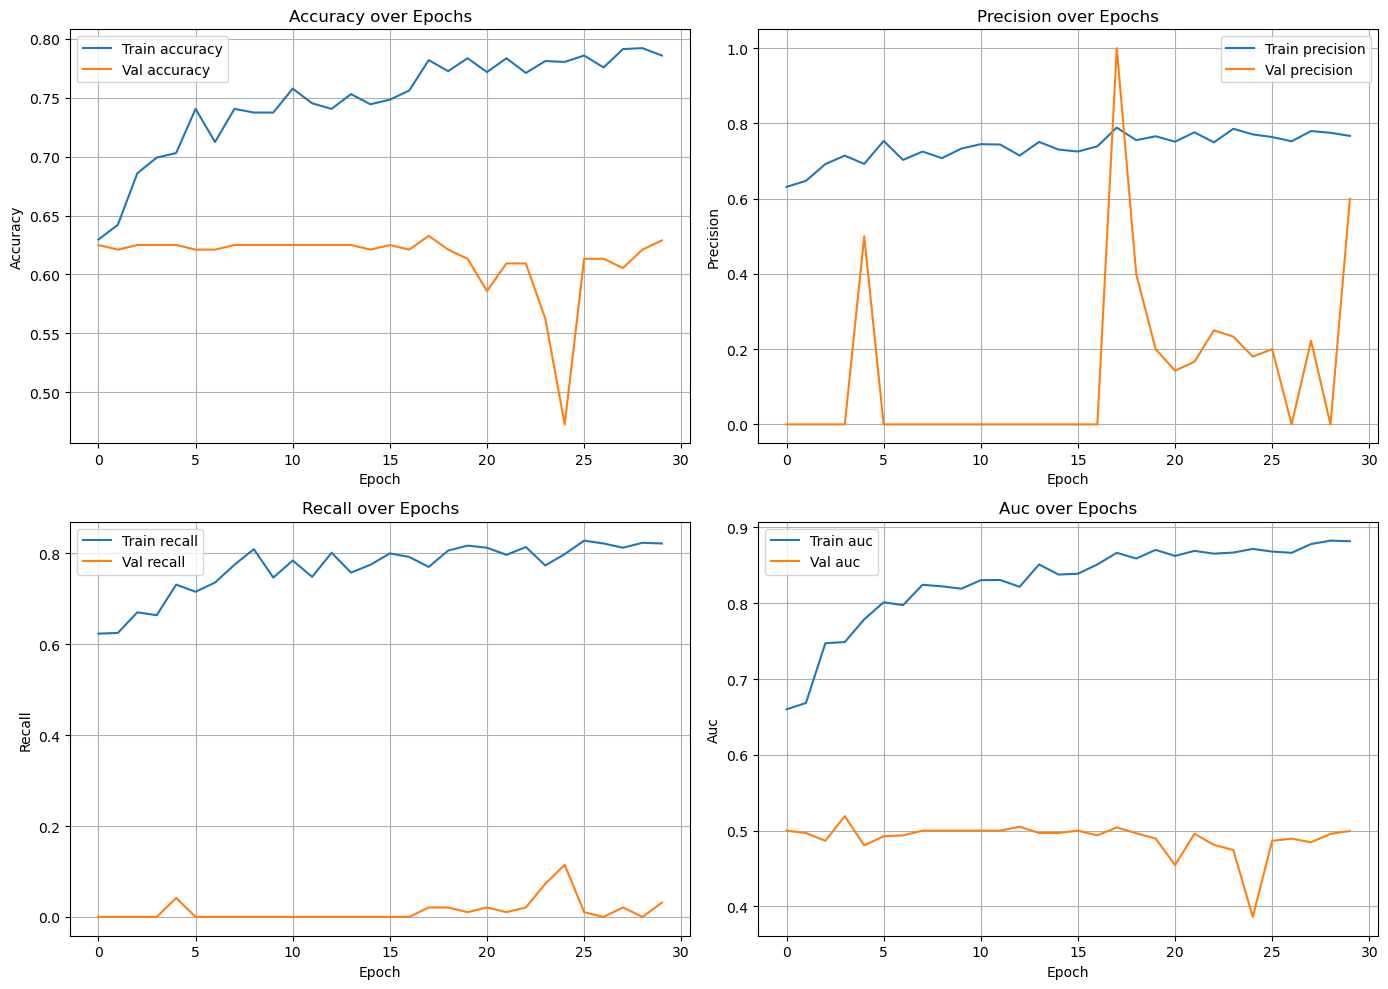

In [15]:
# List of metrics to plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## 4) Hyperparameter tuning

For experimenting we can use fewer epochs (eg 5) and only train the best configurations on all 30 epochs

### Implement early stopping

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',  # You could also use 'val_auc' or another metric
    patience=3,          # Stop after 3 epochs without improvement
    restore_best_weights=True
)

In [17]:
#model.fit(..., callbacks=[early_stop])

### parameter search to tune your model